In [1]:
import sys
import numpy
import pickle
import matplotlib.pyplot as plt, pandas as pd, matplotlib as mpl, random
def utkarshGrid(): plt.minorticks_on() ; plt.grid(color='grey',which='minor',linestyle=":",linewidth='0.1',) ; plt.grid(color='black',which='major',linestyle=":",linewidth='0.1',); return None
def utkarshGridAX(ax): ax.minorticks_on() ; ax.grid(color='grey',which='minor',linestyle=":",linewidth='0.1',) ; ax.grid(color='black',which='major',linestyle=":",linewidth='0.1',); return None
mpl.rcParams['legend.frameon'], mpl.rcParams['figure.autolayout'] = False, True,
colour = ["dodgerblue", "goldenrod", "crimson", "teal", "yellowgreen", "grey"]
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Palatino"],})
def utkarshWrapper(): plt.legend();plt.utkarshGrid() ;plt.gca().tick_params(direction='in', which='both', right=True, top=True); plt.tight_layout(); return None
def utkarshWrapperAX(ax): utkarshGridAX(ax); ax.tick_params(direction='in', which='both', right=True, top=True); return None; 
plt.utkarshGrid = utkarshGrid; plt.utkarshWrapper = utkarshWrapper
def colour_sample(n = 2, col = colour, seed = 7236): random.seed(seed) ; return random.sample(colour, n)
plt.rcParams["image.cmap"] = "Set2" # I recommend, Set2, Dark2
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colour) # Use your own OR plt.cm.Set2.colors

In [2]:
%reload_ext autoreload
%autoreload 2
from run_inference import *
from postprocessing_functions import *

/Users/utkarsh/GitHub/P_NS/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mcmc = None
path = f"results/prior"
mcmc = pickle_read(path)
prior_samples = infer_samples(mcmc)

In [4]:
mcmc = None
path = f"results/posterior"
mcmc = pickle_read(path)
posterior_samples = infer_samples(mcmc)
mcmc.print_summary()


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
             A[0]      0.09      0.56      0.13     -0.73      1.00   3954.69      1.00
       alpha_1[0]     -4.02      0.61     -4.08     -5.00     -3.22   2716.58      1.00
       alpha_2[0]     -0.29      0.52     -0.28     -1.20      0.53   1257.18      1.00
        beta_1[0]      1.27      0.82      1.09      0.15      2.32    149.36      1.00
        beta_2[0]      2.26      0.91      2.16      0.73      3.69    948.94      1.00
      eta_high[0]     25.00     14.60     25.06      0.59     45.54   5110.48      1.00
       eta_low[0]     25.04     14.45     25.18      4.28     48.86   6197.71      1.00
       eta_max[0]      4.51      2.81      4.28      0.03      8.65   3481.59      1.00
       eta_min[0]     30.48     11.41     30.81     13.72     49.28   5850.78      1.00
    gamma_high[0]      6.04      1.21      6.06      4.36      8.00   4598.45      1.00
     gamma_low[0]      2.99    

(array([47., 53., 41., 39., 39., 43., 44., 48., 46., 60., 37., 52., 50.,
        58., 46., 49., 43., 45., 45., 43., 40., 42., 51., 58., 44., 46.,
        42., 35., 49., 47., 44., 51., 52., 46., 53., 41., 48., 56., 59.,
        48., 42., 55., 45., 54., 39., 51., 42., 45., 42., 41., 40., 48.,
        46., 47., 46., 48., 37., 44., 41., 52., 45., 45., 45., 48., 47.,
        48., 60., 47., 62., 45., 57., 63., 50., 62., 60., 57., 66., 64.,
        57., 55., 39., 58., 42., 68., 59., 66., 63., 62., 47., 50., 56.,
        51., 54., 57., 60., 55., 67., 56., 59., 63.]),
 array([-1.99819641, -1.96821526, -1.93823411, -1.90825296, -1.87827181,
        -1.84829066, -1.81830951, -1.78832836, -1.75834721, -1.72836606,
        -1.69838491, -1.66840376, -1.63842261, -1.60844146, -1.57846031,
        -1.54847916, -1.51849801, -1.48851686, -1.45853571, -1.42855456,
        -1.39857341, -1.36859226, -1.33861111, -1.30862996, -1.27864881,
        -1.24866766, -1.21868651, -1.18870536, -1.1587242 , -1.128743

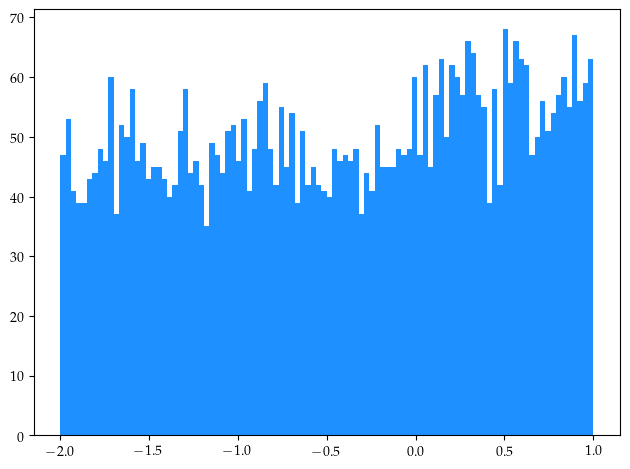

In [14]:
plt.hist(np.log10(posterior_samples["mwidth"]), bins=100)

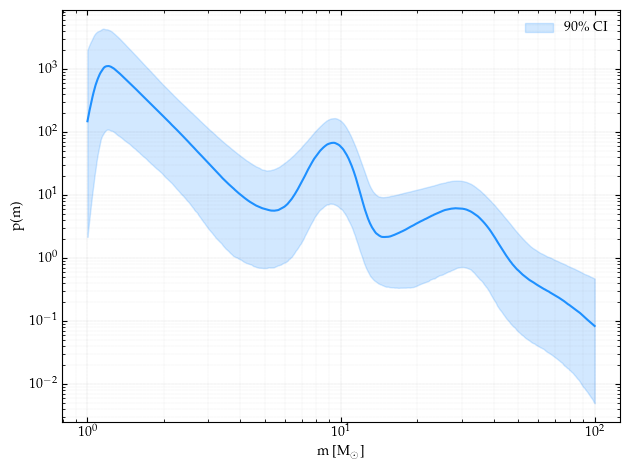

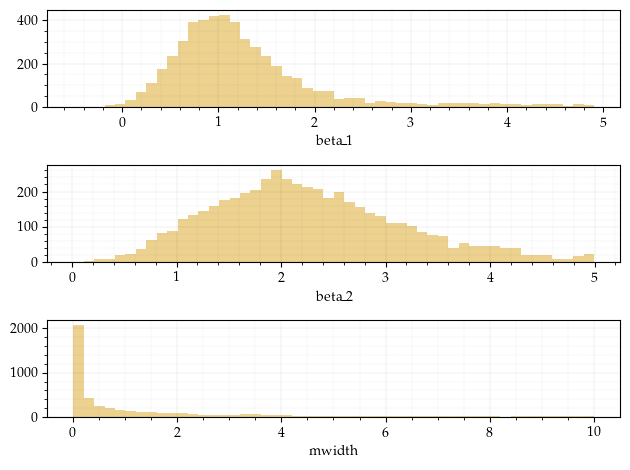

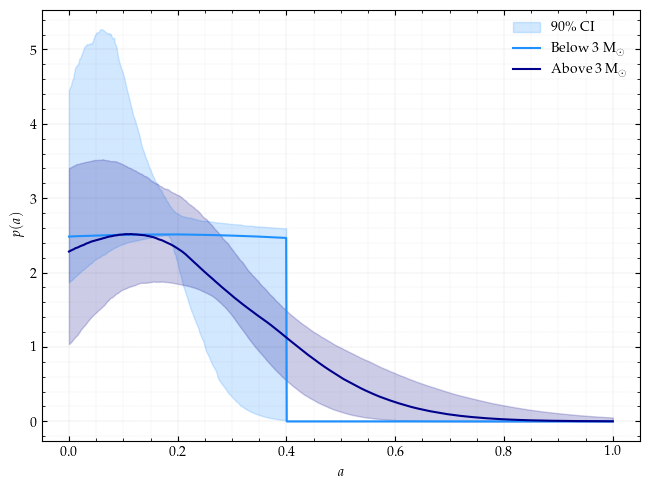

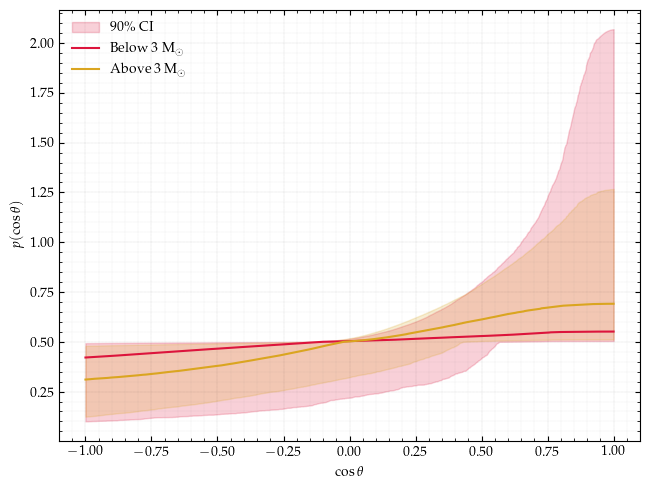

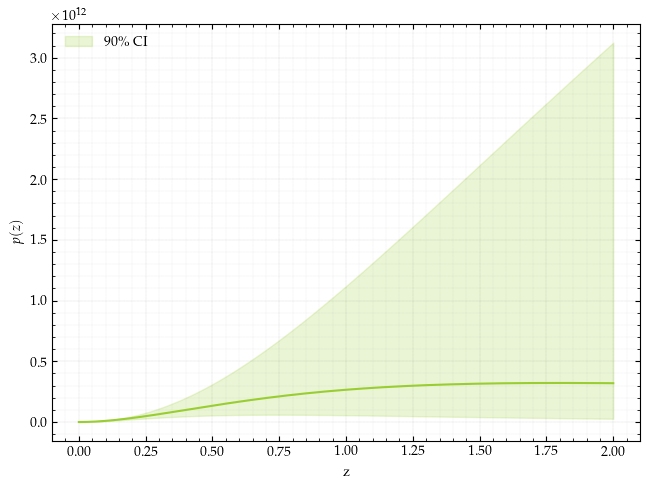

In [5]:
try:
    from config.mass1d_func import pdb_with_NG as mass1d_func
except:
    from config.mass1d_func import multi_pdb as mass1d_func
from config.spin_func import prob_chi, prob_costilt
from config.distance_func import powerlaw_redshift

plot_p_m(posterior_samples, function=mass1d_func)
plot_p_pairing(posterior_samples)
plot_p_chi(posterior_samples, function=prob_chi)
plot_p_costilt(posterior_samples, function=prob_costilt)
plot_p_z(posterior_samples, function=powerlaw_redshift)
plt.show()

Generating trace plots


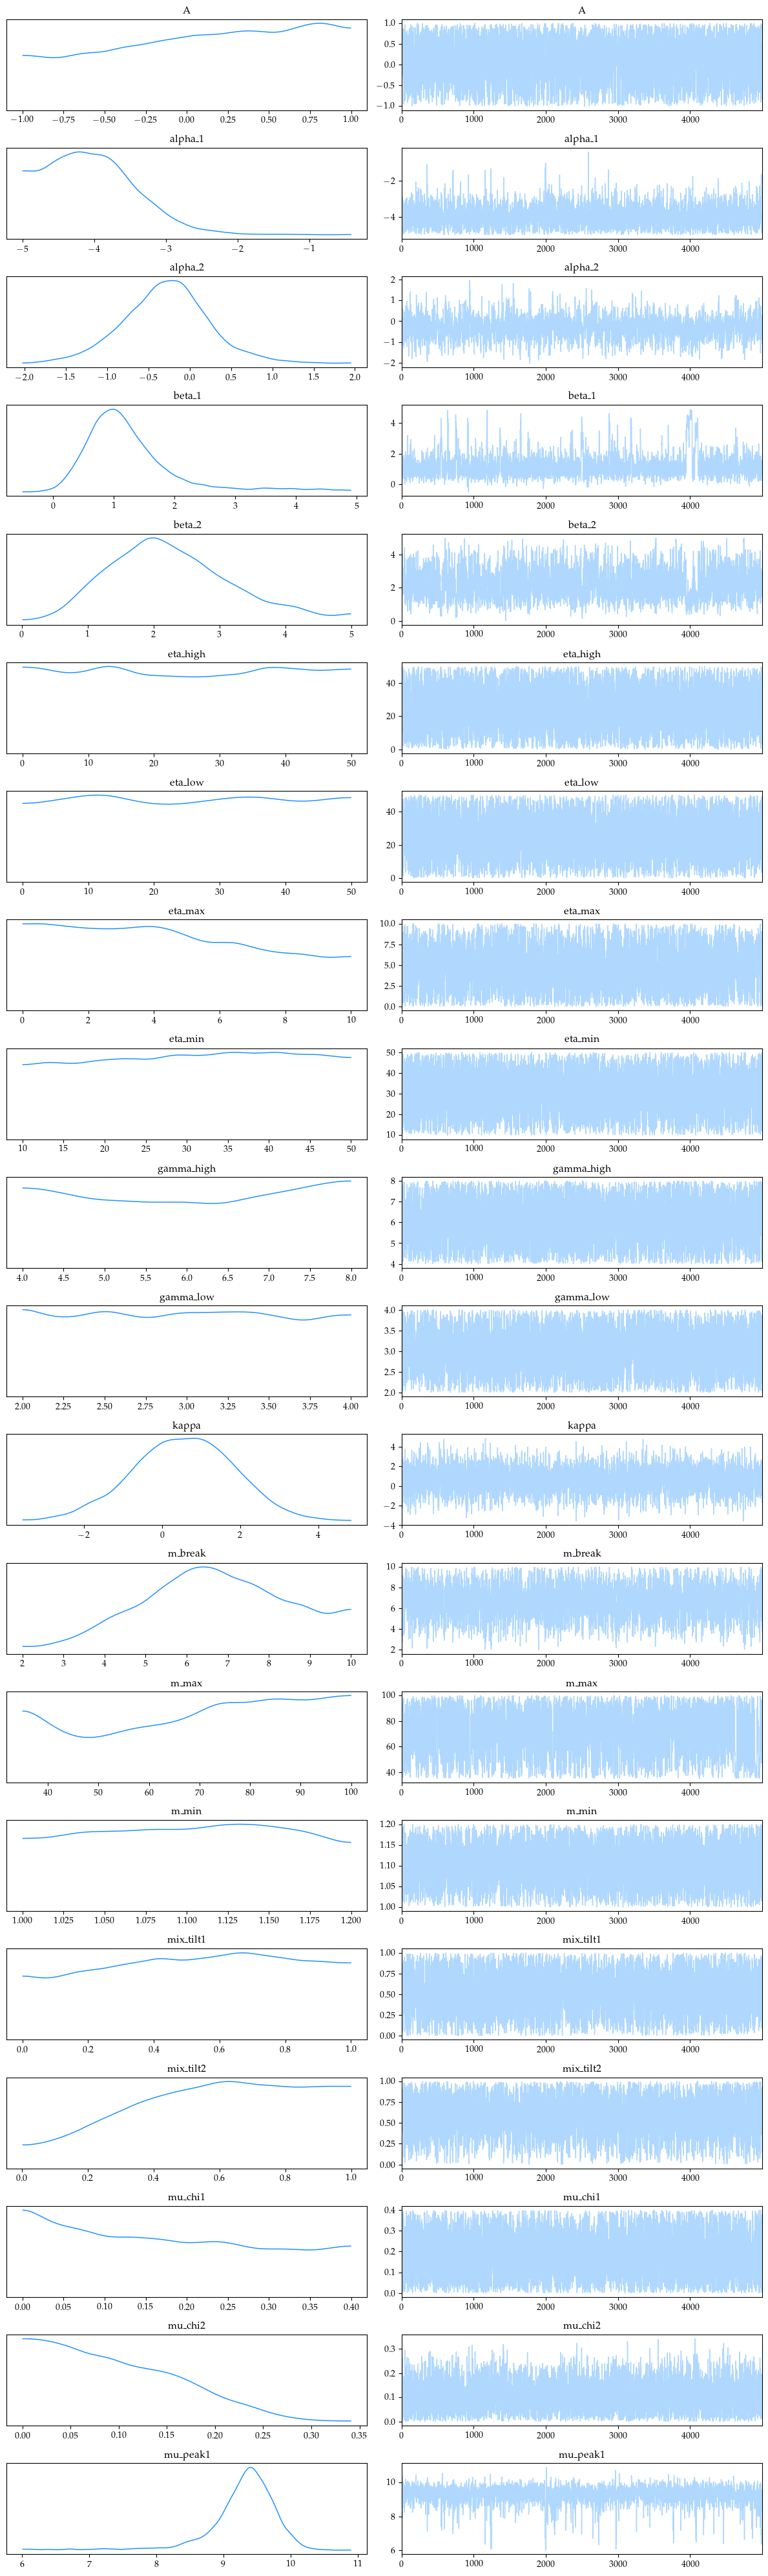

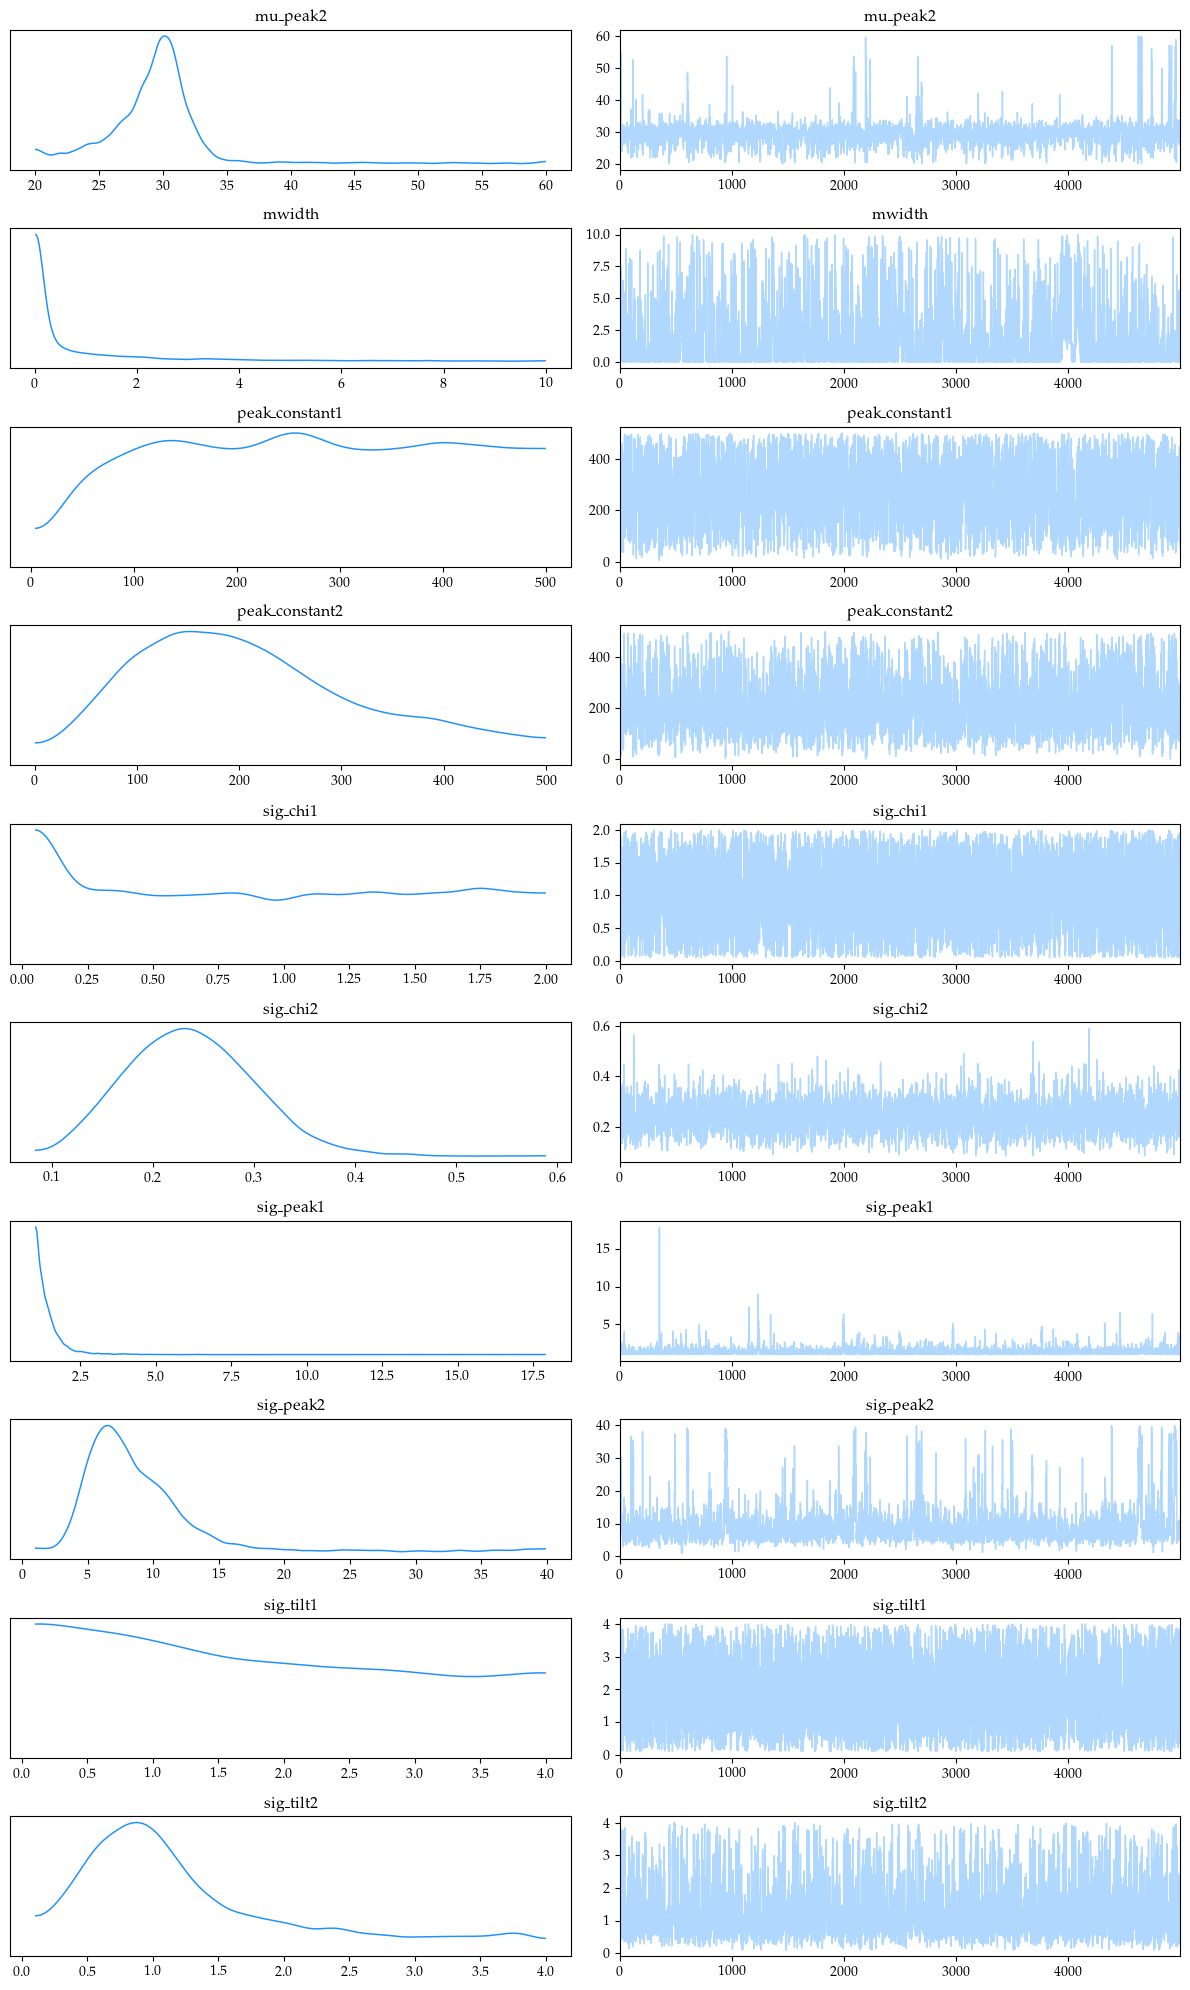

In [6]:
import os
import arviz as az

if os.path.exists("results/trace1.png") or os.path.exists("results/trace2.png") or os.path.exists("results/trace.png"):
    print("Trace plots already exist, skipping generation")
else:
    print("Generating trace plots")
    data = az.from_numpyro(mcmc)
    var_names_lst = get_non_deterministic_params(mcmc)

    if len(var_names_lst) >= 20:
        cut1 = var_names_lst[:20]
        cut2 = var_names_lst[20:]

        assert len(cut1) + len(cut2) == len(var_names_lst)

        az.plot_trace(data, var_names=cut1, compact=True)
        plt.savefig("results/trace1.png")
        az.plot_trace(data, var_names=cut2, compact=True)
        plt.savefig("results/trace2.png")
    else:
        az.plot_trace(data, var_names=var_names_lst, compact=True)
        plt.savefig("results/trace.png")

In [7]:
from model_vector import model_vector

import os

# try:
#     os.remove("results/postprocessed_samples")
# except: pass

if os.path.exists("results/postprocessed_samples"):
    with open("results/postprocessed_samples", "rb") as f:
        postprocessed_posterior_samples = pickle.load(f)
else:
    postprocessed_posterior_samples = add_postprocessing_effects(posterior_samples, model_vector)
    with open("results/postprocessed_samples", "wb") as f:
        pickle.dump(postprocessed_posterior_samples, f)

config = configparser.ConfigParser()
config.read('config/config.ini')
event_folder_name = config["DIRECTORIES"]["event_folder_name"]
event_file_name = config["DIRECTORIES"]["event_file_name"]
translate_dir = "../../"
events = numpy.loadtxt(translate_dir+event_folder_name+event_file_name, dtype=str)

Not in COURSE GRAIN: 66


100%|██████████| 66/66 [00:09<00:00,  7.16it/s]


In COURSE GRAIN: 0


100%|██████████| 5000/5000 [23:05<00:00,  3.61it/s]


In [8]:
for event_i in tqdm(range(len(postprocessed_posterior_samples["neff_events"].T))):
    neff = postprocessed_posterior_samples["neff_events"].T[event_i]
    filename = events[event_i][:14]
    try:
        plot_neff(neff, filename)
        plt.close()
    except:
        continue

100%|██████████| 66/66 [00:19<00:00,  3.36it/s]


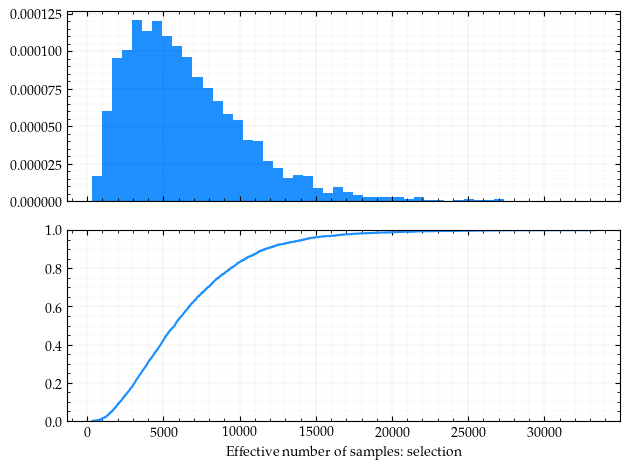

In [9]:
plot_neff(postprocessed_posterior_samples["neff_selection"], "selection")

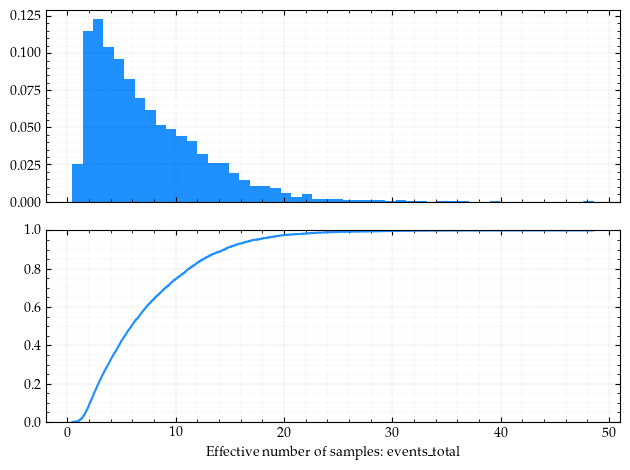

In [10]:
plot_neff(postprocessed_posterior_samples["neff_events_total"], "events_total")

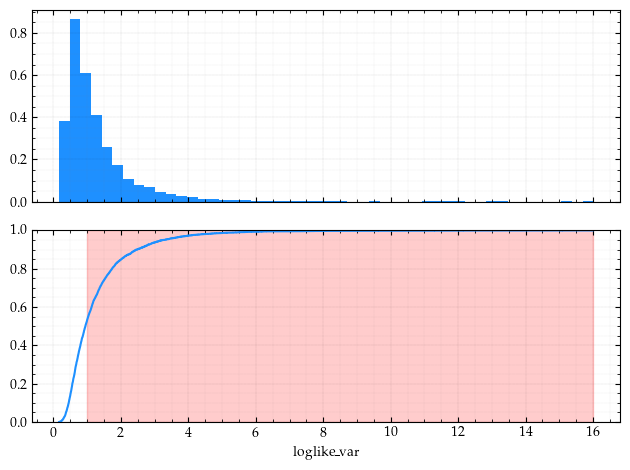

In [11]:
plot_neff(postprocessed_posterior_samples["loglike_var"], "loglike_var")
plt.xlabel("loglike_var")
plt.axvspan(1, max(postprocessed_posterior_samples["loglike_var"]), color = "red", label = "Var samples greater than 1", alpha = 0.2)
plt.savefig("results/loglike_var.png")

/Users/utkarsh/GitHub/P_NS/sampler/runs/multiPDB_betaSplitSmooth_brokenG_1_full/postprocessing_functions.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  def utkarshWrapper(): plt.legend();plt.utkarshGrid();plt.gca().tick_params(direction='in', which='both', right=True,


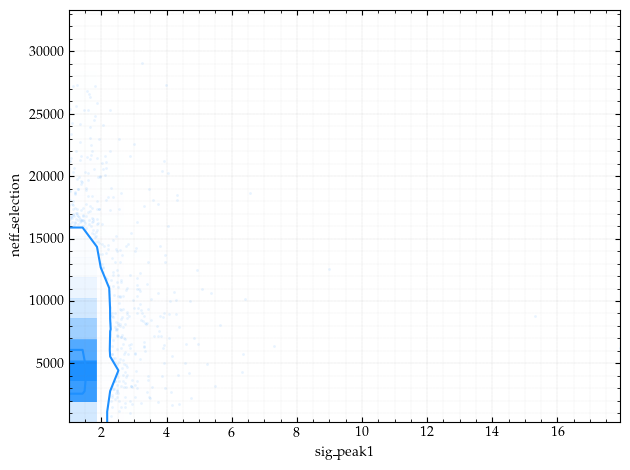

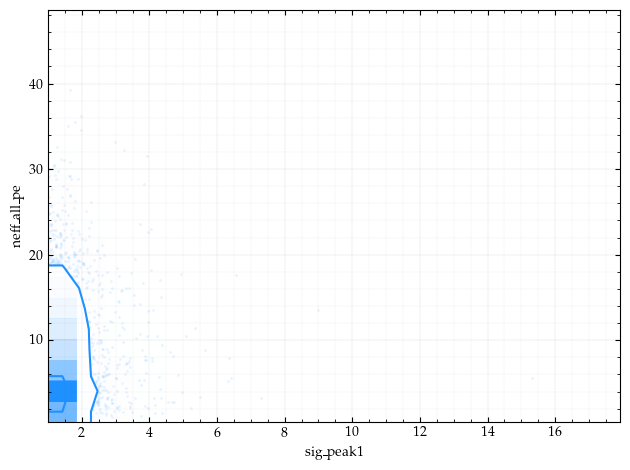

In [12]:

plot_corner(postprocessed_posterior_samples["sig_peak1"], postprocessed_posterior_samples["neff_selection"], "sig_peak1", "neff_selection")
plt.figure()
plot_corner(postprocessed_posterior_samples["sig_peak1"], postprocessed_posterior_samples["neff_events_total"], "sig_peak1", "neff_all_pe")